In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# O2 flux

##### RUN:
/data/tjarniko/results/20aug19_now_write_oxy_variables_attempt2
##### DATE:  Jan17_2019
##### description of point: 

calculate intermediate calculations for oxygen flux. 
check units/check that numbers make sense with literature



In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
#import all the things

import netCDF4 as nc
import matplotlib.pyplot as plt
import datetime
import os
import numpy as np
import cmocean as cm
from salishsea_tools import visualisations as vis
from salishsea_tools import (teos_tools, tidetools, viz_tools)
import xarray as xr 
import subprocess 
import cmocean
from matplotlib import reload
import glob
import netCDF4 as nc
import VIZ_plots as VP

%matplotlib inline

Oxygen is exchanged with the atmosphere using the parameterization
of Wanninkhof (1992) to compute the gas exchange
coefficient. The atmospheric concentration of oxygen
is constant over time and space and cannot be specified by
the user. As for CO2, no air–sea fluxes are allowed when the
ocean is covered by sea ice (see Eq. 82).

In [5]:
reload(VP)

<module 'VIZ_plots' from '/data/tjarniko/MEOPAR/analysis-tereza/notebooks/carbon_dev/MOCSY_and_FLUX/VIZ_plots.py'>

#### Available functions from VP

    two_panel_plot(surfdat_1,surfdat_2,tit1,tit2,t_cmap,xsize,ysize,vmin,vmax,clabel,bigtit)
    animate_surf(hrly_dat,tit,v_min,v_max,t_cmap)

In [13]:
resdir = '/data/tjarniko/results/20aug19_writeout_oxydiag_uncomm_zkgwan_writeout_oceo2/'
ptrc = 'SKOG_1ts_20141121_20141121_carp_T_20141121-20141121.nc'
grid = 'SKOG_1ts_20141121_20141121_grid_T_20141121-20141121.nc'
tracers = nc.Dataset(resdir + ptrc)
tracersp = nc.Dataset(resdir + grid)
#print(tracers)
# print(tracersp)

In [16]:
chemo2 = tracers.variables['of_chemo2'][0,:,:]
zkgo2 = tracers.variables['of_zkgo2'][0,:,:]
#patm = tracers.variables['of_patm'][0,:,:]
o2_surf = tracers.variables['dissolved_oxygen'][0,0,:,:]
oce_o2 = tracers.variables['oce_o2'][0,:,:]
#wm = tracers.variables['wind_mag'][0,:,:]
sal = tracersp.variables['vosaline'][0,0,:,:]
temp = tracersp.variables['votemper'][0,0,:,:]


In [17]:
print('chemo2')
print(np.min(chemo2))
print(np.max(chemo2))
print('zkgo2')
print(np.min(zkgo2))
print(np.max(zkgo2))
# print('patm')
# print(np.min(patm))
# print(np.max(patm))
print('oce_o2')
print(np.min(oce_o2))
print(np.max(oce_o2))
print('o2_surf')
print(np.min(o2_surf))
print(np.max(o2_surf))
# print('wind_mag')
# print(np.min(wm))
# print(np.max(wm))


chemo2
0.00027572436
0.00039639758
zkgo2
0.0
7.9941914e-05
oce_o2
-0.0061143506
0.0042647067
o2_surf
0.0
475.1812


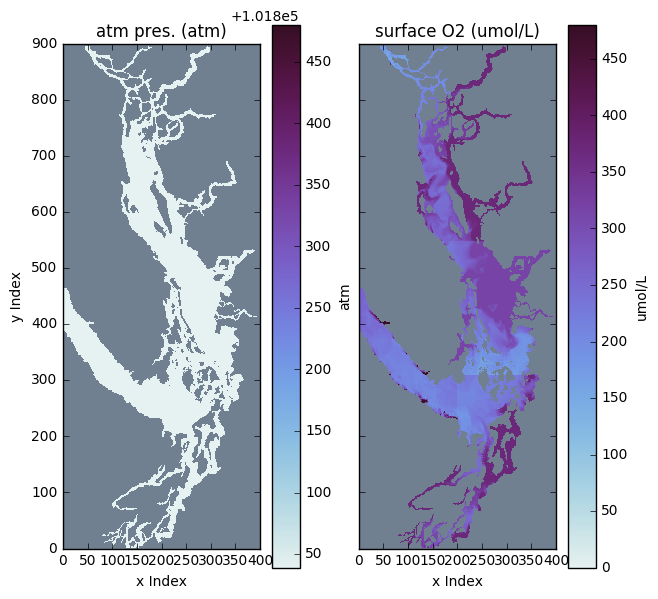

In [19]:
VP.two_panel_plot(o2_surf,o2_surf,'atm pres. (atm)','surface O2 (umol/L)',\
                  cm.cm.dense,7,7,101839.0,102280.0,0,480,'atm','umol/L','')


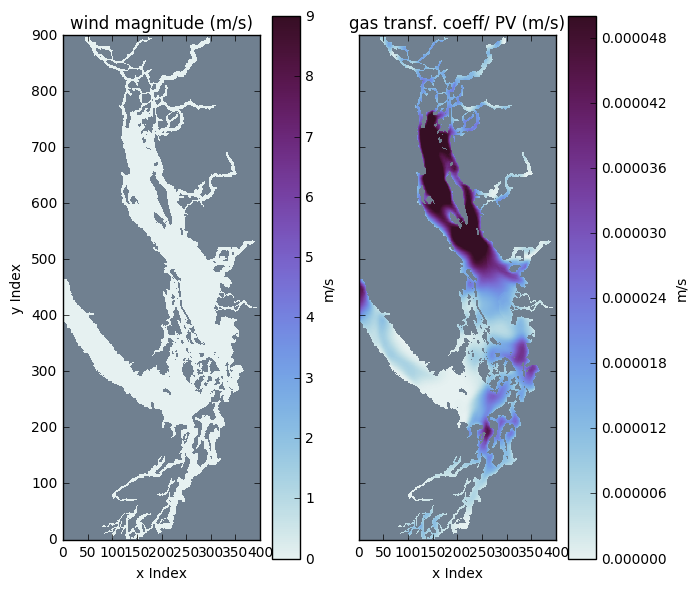

In [18]:
VP.two_panel_plot(zkgo2,zkgo2,'wind magnitude (m/s)','gas transf. coeff/ PV (m/s)',\
                  cm.cm.dense,7,7,0,9,0,5e-5,'m/s','m/s','')


In [ ]:
VP.two_panel_plot(chemo2,oce_o2,'o2 solubility chemo2','o2 flux',\
                  cm.cm.balance,7,7,.000235,.00036,-0.014,0.014,'mol/(L atm)','(mol/L) * (m/s)','')

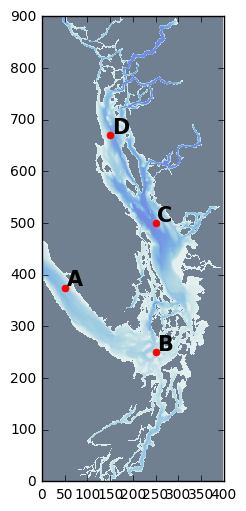

In [20]:
mesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')
bathy = mesh.variables['Bathymetry'][:]

itt = [50,250,250,150]
jtt = [375,250,500,670]
wtt = ['A','B','C','D']
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(bathy, cmap=cmocean.cm.dense, vmin = 0, vmax = 1000)
for w in range(0,len(wtt)):

        ax.plot(itt[w],jtt[w],'r.',markersize=10)
        ax.text(itt[w]+4,jtt[w]+4,wtt[w],fontsize=15,weight='bold')

In [23]:
#o2 conc, temp, sal, schmidt number, wind mag, pist_vel, 
itt = [50.0,250.0,250,150]
jtt = [375,250,500,670]
temptt = np.zeros_like(itt)
saltt = np.zeros_like(itt)
windtt = np.zeros_like(itt)
schtt = np.zeros_like(itt)
pisttt= np.zeros_like(itt)
o2_conc = np.zeros_like(itt)
o2_sol  = np.zeros_like(itt)
o2_flx = np.zeros_like(itt)
itt = [50,250,250,150]

for w in range(0,len(itt)):
    temptt[w] = temp[jtt[w],itt[w]]
    saltt[w]= sal[jtt[w],itt[w]]
    #windtt[w]= wm[jtt[w],itt[w]]
    ztc = temptt[w]
    sc_o2  = 1920.4 - 135.6  * ztc + 5.2122 * ztc**2 - 0.109390 * ztc**3 + 0.0009377 * ztc**4
    schtt[w] = sc_o2
    pisttt[w] = zkgo2[jtt[w],itt[w]]
    o2_sol[w] = chemo2[jtt[w],itt[w]]
    o2_flx[w] = oce_o2[jtt[w],itt[w]]
    o2_conc[w] = o2_surf[jtt[w],itt[w]]


In [ ]:
import pandas as pd


dataset = pd.DataFrame({'i':itt,'j':jtt,'temp (C)':temptt,\
                        'sal':saltt,'schmidt':schtt,'wind (m/s)':windtt,\
                       'pist.vel.(m/s)':pisttt,'o2 sol (mol/(L atm))':o2_sol,\
                        'o2 flux (mmol/L) * (m/s)':o2_flx,'surface o2 (umol/L)':o2_conc})
print(dataset)


## Debby results

    oxe_kg [269.73581118 266.84857296 254.93300235 249.98539583]
    oxqe [276.10352051 273.01032919 259.89805539 255.14090097]
    ox_kg [213.14762279 210.41924407 281.99194926 237.16185758]
    do2 [-0.20979116 -0.21146573  0.1061414  -0.05129715]
    sc_o2 [898.96653585 863.33801114 707.82404711 691.6791655 ]
    ws10 =  [2.14 1.76 7.92 5.85]
    ko2 m/s [2.76468265e-06 1.90820227e-06 4.26753616e-05 2.35531441e-05]
    gf_o2 (mol/m2/s) [ 1.60141692e-07  1.10164961e-07 -1.17724016e-06  3.08263572e-07]

[ 0.00016014  0.00011016 -0.00117724  0.00030826]
[ 6.22062420e-04  1.06243498e-03 -6.37689081e-05  1.91979879e-03]


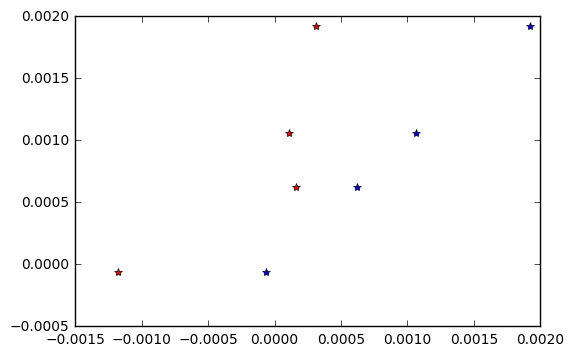

In [27]:
gf_o2_debby = [ 1.60141692e-07,  1.10164961e-07, -1.17724016e-06,  3.08263572e-07]
gf_o2_tereza = o2_flx

gf_o2_mmol_debby = 1000*np.array(gf_o2_debby)
print(gf_o2_mmol_debby)
print(gf_o2_tereza)

plt.plot(gf_o2_mmol_debby,gf_o2_tereza,'r*')
plt.plot(gf_o2_tereza,gf_o2_tereza,'b*')

In [ ]:
np.shape(gf_o2_mmol_debby)

In [ ]:
fig = plt.figure(figsize=(6,6))

for i in range(1,2):
    if i == 1:
        ax1 = fig.add_subplot(1,1,i)
        ax1.plot(gf_o2_tereza,gf_o2_mmol_debby,'r*')
        ax1.plot([-.0015,.0004],[-.0015,.0004],'k')
        ax1.set_ylabel('DEBBY spot check gf o2 (mmol/m2/s)')
        ax1.set_xlabel('TEREZA spot check gf o2 (mmol/m2/s)')
        
